In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

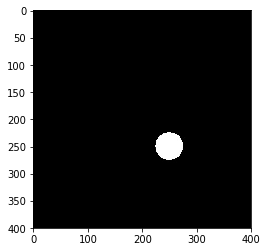

In [10]:
img = plt.imread('img/dot.jpg')
plt.imshow(img, cmap='gray')

In [60]:
def bresenham(p0, p1):
    pts = []
    x0, y0 = p0
    x1, y1 = p1

    dx = abs(x1-x0)
    dy = abs(y1-y0)
    
    if x0 < x1:
        sx = 1
    else:
        sx = -1
        
    if y0 < y1:
        sy = 1
    else:
        sy = -1
        
    err = dx-dy
    while True:
        pts.append((x0,y0))
        if x0 == x1 and y0 == y1:
            return pts
        
        e2 = 2*err
        if e2 > -dy:
            # overshot in the y direction
            err = err - dy
            x0 = x0 + sx
        if e2 < dx:
            # overshot in the x direction
            err = err + dx
            y0 = y0 + sy

In [8]:
def rotate_line(line, origin, angle):
    origin_x, origin_y = origin
    rotated_line = []
    for point in line:
        x, y = point
        rotated_x = int(origin_x + math.cos(angle) * (x - origin_x) - math.sin(angle) * (y - origin_y))
        rotated_y = int(origin_y + math.sin(angle) * (x - origin_x) + math.cos(angle) * (y - origin_y))
        rotated_line.append((rotated_x, rotated_y))
    return rotated_line

In [11]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

(800, 800)

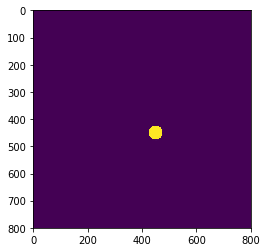

In [111]:
#ADD SOME PADDING AROUND THE PICTURE
gray =rgb2gray(img) / 255
#gray = np.ones((400,400))
#gray = np.ones((400,200))
x,y = gray.shape
b = max(gray.shape)
new = np.zeros((b*2, b*2))
new[int(b-x/2): int(b + x/2), int(b -y/2): int(b + y/2)] = gray
plt.imshow(new)
new.shape

In [112]:
def add_padding(picture):
    x,y = picture.shape
    b = max(picture.shape)
    new = np.zeros((b*2, b*2))
    new[int(b-x/2): int(b + x/2), int(b -y/2): int(b + y/2)] = picture
    return new

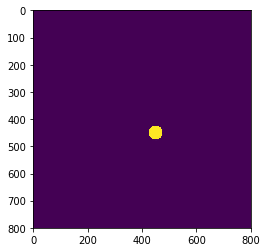

In [113]:
padd = add_padding(gray)
plt.imshow(padd)

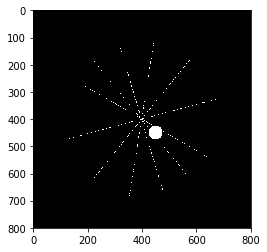

In [114]:
x,y = gray.shape
x2,y2 = padd.shape
r=math.sqrt(x**2 + y**2)/2
vert = bresenham((int(x2/2),int(y2/2+r)),(int(x2/2),int(y2/2-r)))
plt.imshow(padd)
for i in range(1,10,1):
    for point in vert:
        padd[point] = 1
    vert = rotate_line(vert, (int(x2/2), int(y2/2)), math.pi/i)

plt.imshow(padd, cmap='gray')

In [115]:
np.linspace(200,600,10)

array([200.        , 244.44444444, 288.88888889, 333.33333333,
       377.77777778, 422.22222222, 466.66666667, 511.11111111,
       555.55555556, 600.        ])

In [300]:
#generates emitters and detectors vertically
def gen_emitters_and_detectors(n, l, paddImg):
    x2, y2 = paddImg.shape
    x = x2/2
    y = y2/2
    r=math.sqrt(x**2 + y**2)/2
    emitters = [(int(x),int(y2/2 + r)) for x in np.linspace(int(x2/2 - l/2), int(x2/2 + l/2), n)]
    detectors = [(int(x),int(y2/2 - r)) for x in np.linspace(int(x2/2 - l/2), int(x2/2 + l/2), n)]
    return emitters, detectors

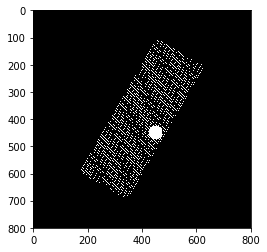

In [123]:
#visualization:
padd = add_padding(gray)
em, det = gen_emitters_and_detectors(40, 200)
for p1,p2 in zip(em, det):
    for point in rotate_line(bresenham(p1,p2), (padd.shape[0]/2, padd.shape[1]/2),math.pi/3 ):
        padd[point] = 1
plt.imshow(padd, cmap='gray')

In [303]:
def gen_sinogram(n,l, alphaStepDeg, img):
    gray = rgb2gray(img) / 255
    paddGray = add_padding(gray)
    center = (int(paddGray.shape[0]/2), int(paddGray.shape[1]/2))

    lines = []
    all_lines=[]
    em, det = gen_emitters_and_detectors(n, l, paddGray)
    for p1,p2 in zip(em, det):
        lines.append(bresenham(p1,p2))
        
    sinogram = np.zeros((n, int(360/alphaStepDeg)))
    i=0
    for alpha in range(0,360,alphaStepDeg):
        rotated = [rotate_line(line, center, (alpha/180)*math.pi) for line in lines]
        for j, line in enumerate(rotated):
            sinogram[j,i] = sum([paddGray[point] for point in line])
        i+=1
        all_lines.append(rotated)
        
    sinogram = sinogram / sinogram.max()
    return sinogram, all_lines

In [254]:
def restore_picture(sinogram, lines, picture_shape):
    x,y = picture_shape[0], picture_shape[1]
    b = max(picture_shape)
    print(b)
    restoration = np.zeros((b*2, b*2))    
    for i, lines_for_alpha in enumerate(lines):
        for j, line in enumerate(lines_for_alpha):
            for px, py in line:
                restoration[px,py] += sinogram[j, i]
    restoration = restoration / restoration.max()
    return restoration[int(b-x/2):int(b+x/2), int(b-y/2):int(b+y/2)]

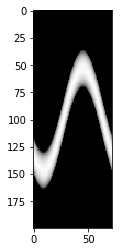

In [305]:
img = plt.imread('img/dot.jpg')
sinogram, lines = gen_sinogram(200, 300, 5, img)
plt.imshow(sinogram, cmap='gray')

400


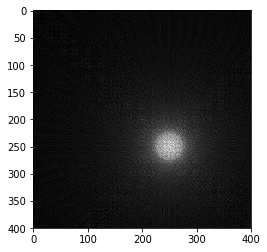

In [306]:
plt.imshow(restore_picture(sinogram, lines, img.shape), cmap='gray')

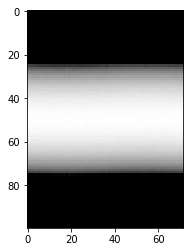

In [250]:
img = plt.imread('img/circle.jpg')
sinogram, lines = gen_sinogram(100, 400, 5, img)
plt.imshow(sinogram, cmap='gray')

400


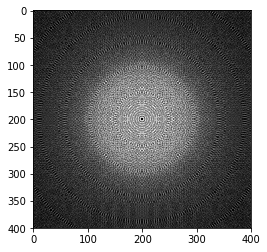

In [251]:
plt.imshow(restore_picture(sinogram, lines, img.shape), cmap='gray')

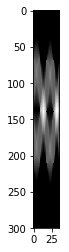

In [261]:
img = plt.imread('img/squares.jpg')
sinogram, lines = gen_sinogram(300, 400, 10, img)
plt.imshow(sinogram, cmap='gray')

384


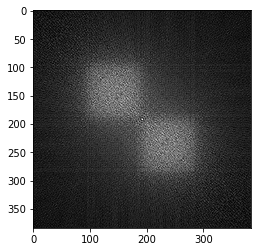

In [262]:
plt.imshow(restore_picture(sinogram, lines, img.shape), cmap='gray')

(1024, 1024, 3)


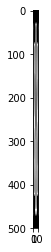

In [709]:
img = plt.imread('img/hgw.jpg')
print(img.shape)
sinogram, lines = gen_sinogram(500, 1000, 30, img)
plt.imshow(sinogram, cmap='gray')

1024


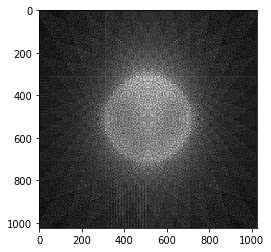

In [310]:
plt.imshow(restore_picture(sinogram, lines, img.shape), cmap='gray')

# Filtering section below

In [693]:
def genKernel(size):
    kernel = []
    for i in range(-int(size/2), int(size/2)):
        if i == 0:
            kernel.append(1)
        elif i % 2 == 0:
            kernel.append(0)
        else:
            kernel.append((-4/(math.pi**2))/i**2)
    return kernel

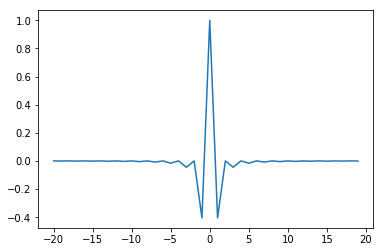

In [694]:
kernel = genKernel(40)
plt.plot(np.arange(-20,20), kernel)

In [638]:
def flatten(sinus):
    x = sinus.copy()
    for i in range(len(x)):
        if x[i] > 0.8 * sinus.max():
            x[i] = 0.8 * sinus.max()
    return x

In [711]:
img = plt.imread('img/hgw.jpg')
sinogram, lines = gen_sinogram(500, 1000, 5, img)
sinus = sinogram[:,0]

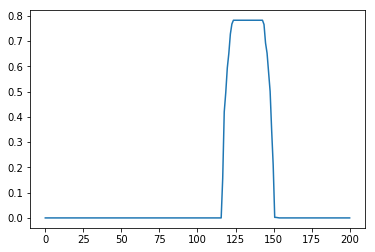

In [666]:
flattened = flatten(sinus)
plt.plot(np.linspace(0,200,200), flattened)

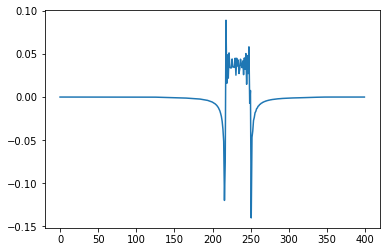

In [667]:
kernel = genKernel(len(sinus))
y = np.convolve(sinus, kernel)
plt.plot(np.linspace(0,len(sinus) + len(kernel)-1,len(sinus) + len(kernel)-1), y)

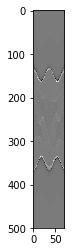

In [712]:
copy = sinogram.copy()
for i in range(sinogram.shape[1]):
    convolution = np.convolve(sinogram[:,i], genKernel(len(sinogram[:,i])))
    convolution = np.append(convolution, 0)
    copy[:,i] = convolution.reshape(-1, 2).mean(axis=1)
plt.imshow(copy, cmap='gray')

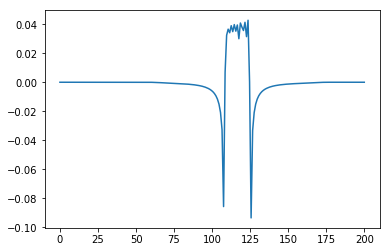

In [688]:
plt.plot(np.linspace(0,200,200), copy[:,0])

1024
0.0


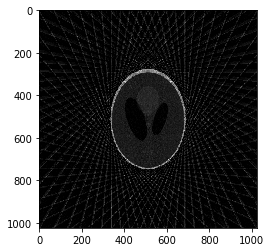

In [713]:
restored = restore_picture(copy, lines, img.shape)

cp = restored.copy()
for i in range(restored.shape[0]):
    for j in range(restored.shape[1]):
        if restored[i,j] < 0:
            cp[i,j] = 0
print(cp.min())
plt.imshow(cp, cmap='gray')